In [1]:
# prompt: 查看实验环境

import platform
import sys

print("Python version:", sys.version)
print("Platform:", platform.platform())
print("System:", platform.system())
print("Node:", platform.node())
print("Release:", platform.release())
print("Version:", platform.version())
print("Machine:", platform.machine())
print("Processor:", platform.processor())
!pip show tensorflow

!cat /proc/cpuinfo | grep 'model name'
!cat /proc/meminfo | grep 'MemTotal'
!df -h
!nvidia-smi  # If you have a GPU


Python version: 3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]
Platform: Linux-6.1.85+-x86_64-with-glibc2.35
System: Linux
Node: 22a96cb320d3
Release: 6.1.85+
Version: #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
Machine: x86_64
Processor: x86_64
Name: tensorflow
Version: 2.18.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine_rl, tensorflow-text, tf_keras
model name	: Intel(R) Xeon(R) CPU @ 2.00GHz
model name	: Intel(R) Xeon(R) CPU @ 2.00GHz
MemTotal:       13290452 kB
Filesystem      Size  Used Avail Use% Mount

# 数据集



## 数据集下载

关于本项目的数据集保存在[Kaggle](https://www.kaggle.com/)的[huizecai/mushroom](https://www.kaggle.com/datasets/huizecai/mushroom)中，下面的单元格可以直接下载该数据集并返回其路径。

In [2]:
import os
import kagglehub

# 使用KaggleHub下载数据集
dataset_name = "huizecai/mushroom"
path = kagglehub.dataset_download(dataset_name)

print("Path to dataset files:", path)

100%|██████████| 436M/436M [00:04<00:00, 99.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/huizecai/mushroom/versions/5


## 计算各蘑菇种类的图片数量

由于tensorflow中会有中文路径异常问题，该数据集中的各种类的文件夹名以“classXX”来命名，并用label.txt来与其中文名进行映射。

In [3]:
dataset_path = path + '/archive/data'
label_path = path + '/archive/label.txt'

# 获取所有子目录（即蘑菇类别）
dir_names = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]

# 读取 label.txt 并解析内容
categories = {}
with open(label_path, 'r', encoding='utf-8') as file:
    for line in file:
        parts = line.strip().split()
        if len(parts) == 2:
            category_name = parts[0]
            category_id = parts[1]
            categories[category_id] = category_name

# 统计每种类别的图像数量
category_counts = {}
for category_id in categories.keys():
    if category_id in dir_names:  # 确保目录存在
        category_dir = os.path.join(dataset_path, category_id)
        num_images = len([f for f in os.listdir(category_dir) if f.endswith('.jpg') or f.endswith('.jpeg')])
        category_counts[categories[category_id]] = num_images

print("Category counts:", category_counts)

Category counts: {'羊肚菌': 170, '牛肝菌': 155, '鸡油菌': 153, '鸡枞菌': 165, '青头菌': 174, '奶浆菌': 182, '干巴菌': 156, '虎掌菌': 177, '白葱牛肝菌': 181, '老人头菌': 137, '猪肚菌': 109, '谷熟菌': 160, '白参菌': 171, '黑木耳': 174, '银耳': 127, '金耳': 157, '猴头菇': 176, '香菇': 168, '平菇': 161, '金针菇': 115, '口蘑': 139, '鹿茸菇': 154, '榆黄蘑': 177, '榛蘑': 172, '草菇': 149, '鸡腿菇': 137, '茶树菇': 159, '蟹味菇': 105, '白玉菇': 136, '红菇': 177, '杏鲍菇': 160, '松茸': 181, '姬松茸': 178, '松露': 151, '竹荪': 178, '虫草花': 177}


## 处理中文字体异常问题

在部分运行环境中，matplotlib可能会出现中文显示异常问题。此处将加载“SimHei”字体以解决该问题。

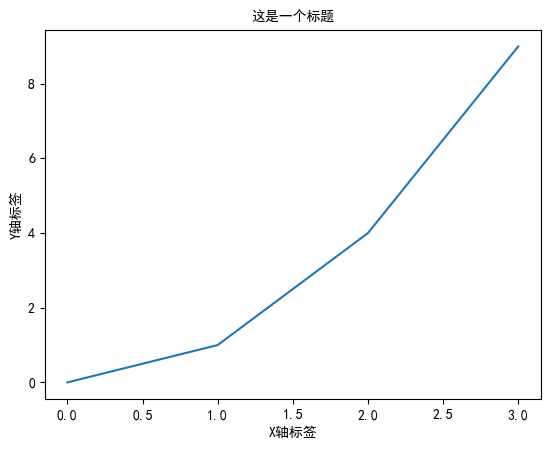

In [4]:
import urllib.request
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties, fontManager

# 下载并保存字体文件
font_url = "https://github.com/caijihuize/Mushroom_Classification/raw/main/SimHei.ttf"
font_name = "SimHei.ttf"
if not os.path.exists(font_name):
    urllib.request.urlretrieve(font_url, font_name)

# 注册字体文件到matplotlib的字体管理器
fontManager.addfont(font_name)

# 设置字体属性
font_prop = FontProperties(fname=font_name)

# 确保matplotlib使用正确的字体族名称
plt.rcParams['font.family'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False

# 示例绘图
plt.title('这是一个标题', fontproperties=font_prop)
plt.xlabel('X轴标签', fontproperties=font_prop)
plt.ylabel('Y轴标签', fontproperties=font_prop)
plt.plot([0, 1, 2, 3], [0, 1, 4, 9])
plt.show()

## 绘制各种类图片数量的柱状图

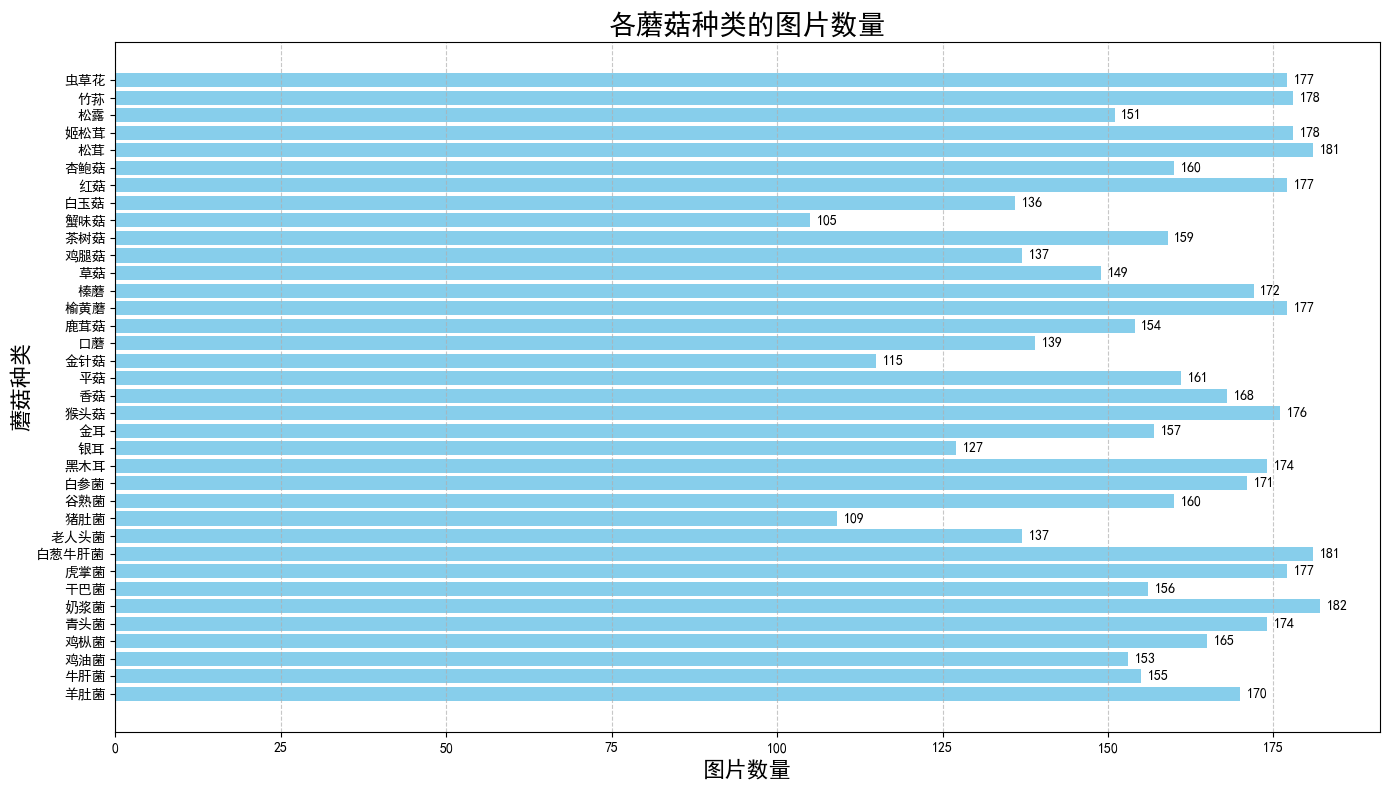

In [5]:
# 准备数据
categories_readable = list(category_counts.keys())
counts = list(category_counts.values())

# 创建一个新的图形
plt.figure(figsize=(14, 8))

# 绘制柱状图
bars = plt.barh(categories_readable, counts, color='skyblue')

# 添加数据标签
for bar in bars:
    width = bar.get_width()
    plt.text(width + 1, bar.get_y() + bar.get_height()/2, '%d' % int(width), va='center')

# 设置标题和标签
plt.title('各蘑菇种类的图片数量', fontsize=20)
plt.xlabel('图片数量', fontsize=16)
plt.ylabel('蘑菇种类', fontsize=16)

# 设置网格
plt.grid(axis='x', linestyle='--', alpha=0.7)
# 自动调整布局
plt.tight_layout()

# 显示图形
plt.show()

# 训练准备工作

## 加载图像数据集

使用 TensorFlow 的 [image_dataset_from_directory](https://tensorflow.google.cn/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory?hl=en) 函数加载和准备图像数据集：


*   directory=dataset_path ：指定图像数据所在的路径。
*   image_size=(224, 224) ：指定每个图像的大小为224x224像素。
*   batch_size=32 ：指定每个批次包含32张图像。
*   validation_split=0.1 ：指定10%的数据作为验证集。
*   subset='both' ：指定同时返回训练集和验证集。
*   label_mode='categorical' ：指定标签模式为分类模式，返回one-hot编码的标签。
*   seed=21 ：设置随机种子以确保数据集的可重复性。



In [6]:
import tensorflow as tf

# 加载和准备图像数据集
train_dataset, validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory=dataset_path,
    image_size=(224, 224),
    batch_size=32,
    validation_split=0.1,
    subset='both',
    label_mode='categorical',
    seed=44
)

Found 5698 files belonging to 36 classes.
Using 5129 files for training.
Using 569 files for validation.


## 计算训练集和验证集的各种类图片分布

In [7]:
import numpy as np

# 获取类别名称
class_names = train_dataset.class_names

# 初始化字典用于存储每种类别的图像数量
train_category_counts = {name: 0 for name in categories.values()}
validation_category_counts = {name: 0 for name in categories.values()}

# 统计训练集中的图像数量
for images, labels in train_dataset:
    for label in labels.numpy():
        category_name = class_names[np.argmax(label)]
        train_category_counts[categories[category_name]] += 1

# 统计验证集中的图像数量
for images, labels in validation_dataset:
    for label in labels.numpy():
        category_name = class_names[np.argmax(label)]
        validation_category_counts[categories[category_name]] += 1


print("训练集类别图像数量统计:", train_category_counts)
print("验证集类别图像数量统计:", validation_category_counts)

训练集类别图像数量统计: {'羊肚菌': 150, '牛肝菌': 142, '鸡油菌': 133, '鸡枞菌': 144, '青头菌': 157, '奶浆菌': 163, '干巴菌': 141, '虎掌菌': 162, '白葱牛肝菌': 162, '老人头菌': 123, '猪肚菌': 96, '谷熟菌': 145, '白参菌': 159, '黑木耳': 157, '银耳': 115, '金耳': 138, '猴头菇': 157, '香菇': 154, '平菇': 140, '金针菇': 104, '口蘑': 126, '鹿茸菇': 132, '榆黄蘑': 161, '榛蘑': 151, '草菇': 133, '鸡腿菇': 125, '茶树菇': 143, '蟹味菇': 101, '白玉菇': 119, '红菇': 156, '杏鲍菇': 146, '松茸': 164, '姬松茸': 159, '松露': 143, '竹荪': 165, '虫草花': 163}
验证集类别图像数量统计: {'羊肚菌': 20, '牛肝菌': 13, '鸡油菌': 20, '鸡枞菌': 21, '青头菌': 17, '奶浆菌': 19, '干巴菌': 15, '虎掌菌': 15, '白葱牛肝菌': 19, '老人头菌': 14, '猪肚菌': 13, '谷熟菌': 15, '白参菌': 12, '黑木耳': 17, '银耳': 12, '金耳': 19, '猴头菇': 19, '香菇': 14, '平菇': 21, '金针菇': 11, '口蘑': 13, '鹿茸菇': 22, '榆黄蘑': 16, '榛蘑': 21, '草菇': 16, '鸡腿菇': 12, '茶树菇': 16, '蟹味菇': 4, '白玉菇': 17, '红菇': 21, '杏鲍菇': 14, '松茸': 17, '姬松茸': 19, '松露': 8, '竹荪': 13, '虫草花': 14}


## 绘制训练集和验证集的柱状图

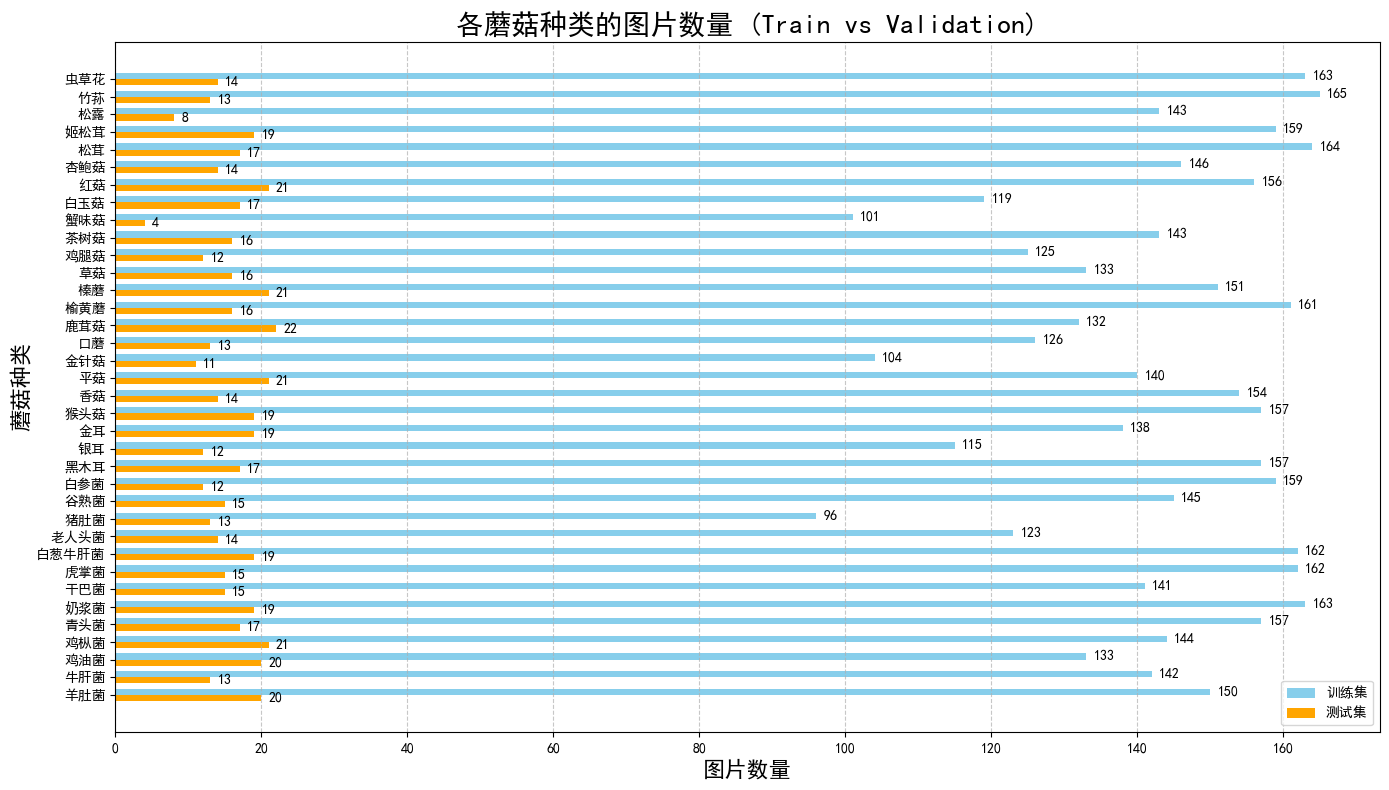

In [8]:
# 准备数据
categories_readable = list(categories.values())  # 使用中文名映射
train_counts = [train_category_counts[name] for name in categories_readable]
validation_counts = [validation_category_counts[name] for name in categories_readable]

# 创建一个新的图形
plt.figure(figsize=(14, 8))

# 设置柱子的位置
bar_width = 0.35
index = np.arange(len(categories_readable))

# 绘制训练集柱状图
bars_train = plt.barh(index + bar_width, train_counts, bar_width, label='训练集', color='skyblue')

# 绘制验证集柱状图
bars_validation = plt.barh(index, validation_counts, bar_width, label='测试集', color='orange')

# 添加数据标签
def add_labels(bars):
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 1, bar.get_y() + bar.get_height() / 2, '%d' % int(width), ha='left', va='center')

add_labels(bars_train)
add_labels(bars_validation)

# 设置标题和标签
plt.title('各蘑菇种类的图片数量 (Train vs Validation)', fontsize=20)
plt.xlabel('图片数量', fontsize=16)
plt.ylabel('蘑菇种类', fontsize=16)

# 设置Y轴刻度
plt.yticks(index + bar_width / 2, categories_readable)

# 显示网格
plt.grid(axis='x', linestyle='--', alpha=0.7)

# 添加图例
plt.legend()

# 自动调整布局
plt.tight_layout()

# 显示图形
plt.show()

## 显示数据集中的图像样本

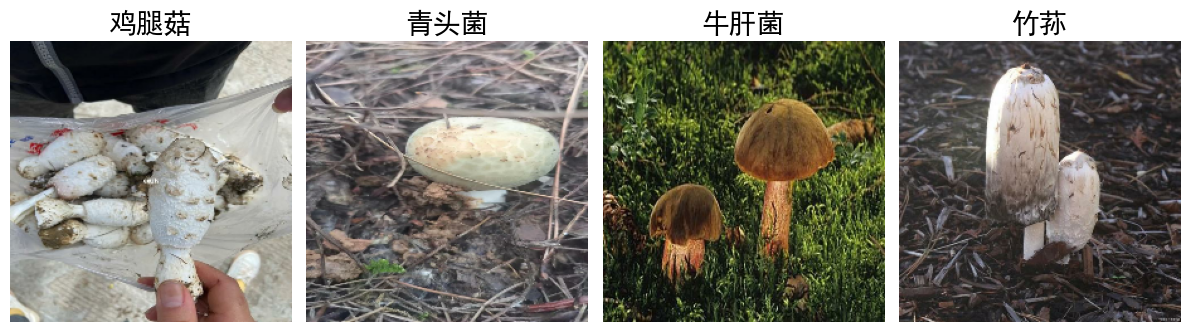

In [9]:
# 获取类别名称
class_names = train_dataset.class_names

# 设置要显示的图像数量
num_images_to_show = 4
images_to_display = []
labels_to_display = []

# 从数据集中获取随机选择的图像和标签
for images, labels in train_dataset.take(1):
    indices = np.random.choice(range(images.shape[0]), num_images_to_show, replace=False)
    for index in indices:
        images_to_display.append(images[index])
        labels_to_display.append(labels[index])

# 创建图形并显示图像
fig, axes = plt.subplots(1, num_images_to_show, figsize=(12, 4))
for i, (image, label) in enumerate(zip(images_to_display, labels_to_display)):
    ax = axes[i]
    ax.imshow(image.numpy().astype("uint8"))
    ax.set_title(categories[class_names[np.argmax(label.numpy())]], fontsize=20)
    ax.axis("off")

plt.tight_layout()
plt.show()

# 数据增强

数据增强是一种常用的技术，用于通过变换现有数据来增加训练数据的多样性，从而提高模型的泛化能力。在图像处理中，常见的数据增强技术包括旋转、翻转、缩放、裁剪、亮度调整等。

## 定义数据增强层

In [10]:
# 定义数据增强的预处理层
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),  # 水平翻转
    tf.keras.layers.RandomRotation(0.2),       # 随机旋转最多20%
    tf.keras.layers.RandomZoom(0.2, 0.2),      # 随机缩放
    tf.keras.layers.RandomContrast(0.2),       # 随机对比度调整
    tf.keras.layers.RandomBrightness(0.2)      # 随机亮度调整
])

## 定义显示数据增强示例函数

In [11]:
def demo_augmentation(sample_image, model, num_aug):
    '''Takes a single image array, then uses a model to generate num_aug transformations'''

    # Instantiate preview list
    image_preview = []

    # Convert input image to a PIL image instance
    sample_image_pil = tf.keras.utils.array_to_img(sample_image)

    # Append the result to the list
    image_preview.append(sample_image_pil)

    # Apply the image augmentation and append the results to the list
    for i in range(NUM_AUG):
        sample_image_aug = model(tf.expand_dims(sample_image, axis=0))
        sample_image_aug_pil = tf.keras.utils.array_to_img(tf.squeeze(sample_image_aug))
        image_preview.append(sample_image_aug_pil)

    # Instantiate a subplot
    fig, axes = plt.subplots(1, NUM_AUG + 1, figsize=(12, 12))

    # Preview the images.
    for index, ax in enumerate(axes):
        ax.imshow(image_preview[index])
        ax.set_axis_off()

        if index == 0:
            ax.set_title('original')
        else:
            ax.set_title(f'augment {index}')

## 获取随机批次

In [12]:
# 获取训练集中随机的一批次图片
sample_batch = list(train_dataset.take(1))[0][0]
print(f'images per batch: {len(sample_batch)}')

images per batch: 32


## 显示数据增强示例

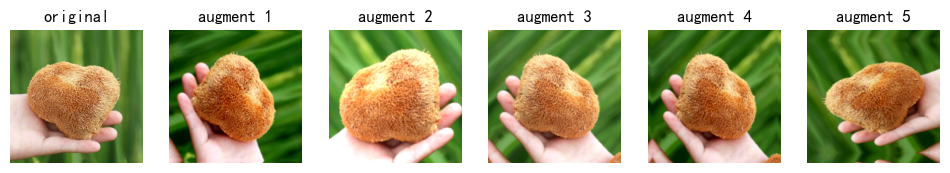

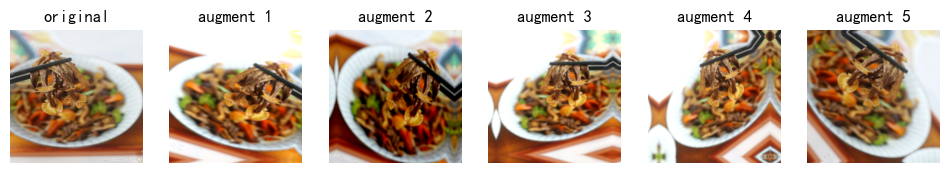

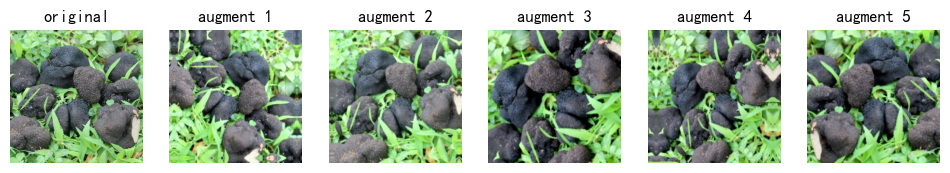

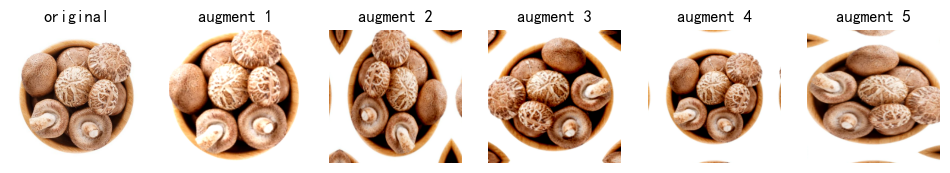

In [13]:
NUM_AUG = 5

# Apply the transformations to the first 4 images
demo_augmentation(sample_batch[0], data_augmentation, NUM_AUG)
demo_augmentation(sample_batch[1], data_augmentation, NUM_AUG)
demo_augmentation(sample_batch[2], data_augmentation, NUM_AUG)
demo_augmentation(sample_batch[3], data_augmentation, NUM_AUG)

# 常用显示函数

In [14]:
# 训练模型
def train_model(model, train_dataset=train_dataset, validation_dataset=validation_dataset, epochs=30):
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)

    history = model.fit(train_dataset, epochs=epochs, validation_data=validation_dataset, callbacks=[early_stopping, lr_scheduler])

    return history

In [15]:
# 量化与格式转换
def quantize_and_convert_to_tflite(model):
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]

    tflite_quant_model = converter.convert()

    return tflite_quant_model

def save_model(model, output_path):
  with open(output_path, 'wb') as f:
    f.write(model)

In [16]:
def show_history(history):
  # 绘制训练过程中的损失和准确率曲线
  plt.figure(figsize=(12, 4))

  plt.subplot(1, 2, 1)
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.title('Loss Over Epochs')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(history.history['accuracy'], label='Training Accuracy')
  plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
  plt.title('Accuracy Over Epochs')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.tight_layout()
  plt.show()

In [17]:
def combine_history(histories, labels):
  min_epochs = min([len(history.history['loss']) for history in histories])
  epochs = range(1, min_epochs + 1)

  plt.figure(figsize=(14, 6))

  # (1) 绘制损失曲线
  plt.subplot(1, 2, 1)
  for i, history in enumerate(histories):
      train_loss = history.history['loss'][:min_epochs]
      val_loss = history.history['val_loss'][:min_epochs]
      plt.plot(epochs, train_loss, label=f'{labels[i]} Train Loss', linestyle='--')
      plt.plot(epochs, val_loss, label=f'{labels[i]} Val Loss')

  plt.title('Training and Validation Loss Comparison')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)

  # (2) 绘制准确率曲线（如果需要）
  plt.subplot(1, 2, 2)
  for i, history in enumerate(histories):
      train_acc = history.history['accuracy'][:min_epochs]
      val_acc = history.history['val_accuracy'][:min_epochs]
      plt.plot(epochs, train_acc, label=f'{labels[i]} Train Accuracy', linestyle='--')
      plt.plot(epochs, val_acc, label=f'{labels[i]} Val Accuracy')

  plt.title('Training and Validation Accuracy Comparison')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.grid(True)

  # 显示图表
  plt.tight_layout()
  plt.show()

In [18]:
from IPython.display import clear_output

# 在训练完成后计算每个类别的准确率
def calculate_class_accuracies(model, dataset):
    all_predictions = []
    all_true_labels = []

    for images, labels in dataset:
        predictions = model.predict(images)
        predicted_classes = np.argmax(predictions, axis=1)
        true_classes = np.argmax(labels, axis=1)

        all_predictions.extend(predicted_classes)
        all_true_labels.extend(true_classes)

    class_accuracies = {}
    for class_index in range(len(class_names)):
        mask = (np.array(all_true_labels) == class_index)
        correct_predictions = np.sum(np.array(all_predictions)[mask] == class_index)
        total_samples = np.sum(mask)
        if total_samples > 0:
            accuracy = correct_predictions / total_samples
        else:
            accuracy = 0
        class_accuracies[class_names[class_index]] = accuracy

    clear_output(wait=True)

    # 准备数据
    categories_readable = list(categories[class_name] for class_name in class_accuracies.keys())
    accuracies = list(class_accuracies.values())

    # 创建一个新的图形
    plt.figure(figsize=(14, 8))

    # 绘制柱状图
    bars = plt.barh(categories_readable, accuracies, color='skyblue')

    # 添加数据标签
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 0.01, bar.get_y() + bar.get_height()/2, f'{width:.4f}', va='center')

    # 设置标题和标签
    plt.title('各类别准确率', fontsize=20)
    plt.xlabel('准确率', fontsize=16)
    plt.ylabel('类别', fontsize=16)

    # 设置网格
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    # 自动调整布局
    plt.tight_layout()

    # 显示图形
    plt.show()

    return class_accuracies

In [32]:
def evaluate_model(model, dataset):
        """使用TensorFlow内置metrics评估Keras模型在数据集上的性能"""
        # 计算模型大小 (MB)
        model_size_mb = sum(np.prod(w.shape) for w in model.get_weights()) * 4 / (1024 * 1024)  # 假设浮点数为4字节

        # 创建评估指标
        top1_accuracy = tf.keras.metrics.CategoricalAccuracy()
        top5_accuracy = tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='top5_accuracy')

        # 在数据集上运行评估
        loss_object = tf.keras.losses.CategoricalCrossentropy()
        loss_avg = tf.keras.metrics.Mean()

        for images, labels in dataset:
            predictions = model(images, training=False)
            loss = loss_object(labels, predictions)

            loss_avg.update_state(loss)
            top1_accuracy.update_state(labels, predictions)
            top5_accuracy.update_state(labels, predictions)

        # 获取结果
        loss = loss_avg.result().numpy()
        top1 = top1_accuracy.result().numpy()
        top5 = top5_accuracy.result().numpy()

        print(f"Loss: {loss:.4f}")
        print(f"Top-1 Accuracy: {top1:.4f}")
        print(f"Top-5 Accuracy: {top5:.4f}")
        print(f"Model Size: {model_size_mb:.2f} MB")

        return top1, top5, model_size_mb

def evaluate_tflite_model(tflite_model, dataset):
    """使用TensorFlow Lite工具简化的评估函数"""
    # 计算TFLite模型大小 (MB)
    model_size_mb = len(tflite_model) / (1024 * 1024)

    # 创建TFLite解释器
    interpreter = tf.lite.Interpreter(model_content=tflite_model)
    interpreter.allocate_tensors()

    # 获取输入输出细节
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # 创建评估指标
    top1_accuracy = tf.keras.metrics.Accuracy()
    top5_accuracy = tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5)

    # 评估进度计数器
    total_samples = 0

    # 遍历数据集
    for images, labels in dataset:
        # 获取标签的真实类别（稀疏形式）
        true_labels = tf.argmax(labels, axis=1).numpy()

        batch_size = images.shape[0]
        batch_predictions = np.zeros((batch_size, len(class_names)), dtype=np.float32)

        # 逐个样本进行推理
        for i in range(batch_size):
            total_samples += 1

            # 预处理输入
            input_data = np.expand_dims(images[i].numpy(), axis=0).astype(np.float32)

            # 设置输入张量
            interpreter.set_tensor(input_details[0]['index'], input_data)

            # 运行推理
            interpreter.invoke()

            # 获取输出并保存
            batch_predictions[i] = interpreter.get_tensor(output_details[0]['index'])[0]

        # 更新指标（整个批次一次更新）
        top1_accuracy.update_state(
            true_labels,
            np.argmax(batch_predictions, axis=1)
        )
        top5_accuracy.update_state(
            true_labels,
            batch_predictions
        )

    # 获取结果
    top1 = top1_accuracy.result().numpy()
    top5 = top5_accuracy.result().numpy()

    print(f"TFLite模型 Top-1 准确率: {top1:.4f}")
    print(f"TFLite模型 Top-5 准确率: {top5:.4f}")
    print(f"TFLite模型大小: {model_size_mb:.2f} MB")

    return top1, top5, model_size_mb

# MobileNetV1模型

In [19]:
def get_MobileNetV1():
  # 初始化基础模型
  pre_trained_model = tf.keras.applications.MobileNet(
      input_shape=(224, 224, 3),
      include_top=False,
      weights='imagenet'
  )

  # 冻结基础模型的权重
  for layer in pre_trained_model.layers:
      layer.trainable = False

  # 应用数据增强和预处理
  x = data_augmentation(pre_trained_model.input)
  x = tf.keras.applications.mobilenet.preprocess_input(x)

  # 添加自定义顶层分类器
  x = pre_trained_model(x)
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  x = tf.keras.layers.Dropout(0.5)(x)
  x = tf.keras.layers.Dense(128, activation='relu')(x)
  x = tf.keras.layers.Dense(256, activation='relu')(x)
  predictions = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

  # 构建最终模型
  MobileNetV1 = tf.keras.models.Model(inputs=pre_trained_model.input, outputs=predictions)

  return MobileNetV1

# MobileNetV2模型

In [20]:
def get_MobileNetV2():
  # 初始化基础模型
  pre_trained_model = tf.keras.applications.MobileNetV2(
      input_shape=(224, 224, 3),
      include_top=False,
      weights='imagenet'
  )

  # 冻结基础模型的权重
  for layer in pre_trained_model.layers:
      layer.trainable = False

  # 应用数据增强和预处理
  x = data_augmentation(pre_trained_model.input)
  x = tf.keras.applications.mobilenet_v2.preprocess_input(x)

  # 添加自定义顶层分类器
  x = pre_trained_model(x)
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  x = tf.keras.layers.Dropout(0.5)(x)
  x = tf.keras.layers.Dense(128, activation='relu')(x)
  x = tf.keras.layers.Dense(256, activation='relu')(x)
  predictions = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

  # 构建最终模型
  MobileNetV2 = tf.keras.models.Model(inputs=pre_trained_model.input, outputs=predictions)

  return MobileNetV2

# EfficientNet模型

In [21]:
def get_EfficientNetB0():
  # 初始化基础模型
  pre_trained_model = tf.keras.applications.EfficientNetB0(
      input_shape=(224, 224, 3),
      include_top=False,
      weights='imagenet'
  )

  # 冻结基础模型的权重
  for layer in pre_trained_model.layers:
      layer.trainable = False

  # 应用数据增强和预处理
  x = data_augmentation(pre_trained_model.input)
  x = tf.keras.applications.efficientnet.preprocess_input(x)

  # 添加自定义顶层分类器
  x = pre_trained_model(x)
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  x = tf.keras.layers.Dropout(0.5)(x)
  x = tf.keras.layers.Dense(128, activation='relu')(x)
  x = tf.keras.layers.Dense(256, activation='relu')(x)
  predictions = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

  # 构建最终模型
  EfficientNetB0 = tf.keras.models.Model(inputs=pre_trained_model.input, outputs=predictions)

  return EfficientNetB0

# ResNet模型

In [22]:
def get_ResNet101():
  # 初始化基础模型
  pre_trained_model = tf.keras.applications.ResNet101(
      input_shape=(224, 224, 3),
      include_top=False,
      weights='imagenet'
  )

  # 冻结基础模型的权重
  for layer in pre_trained_model.layers:
      layer.trainable = False

  # 应用数据增强和预处理
  x = data_augmentation(pre_trained_model.input)
  x = tf.keras.applications.resnet.preprocess_input(x)

  # 添加自定义顶层分类器
  x = pre_trained_model(x)
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  x = tf.keras.layers.Dropout(0.5)(x)
  x = tf.keras.layers.Dense(128, activation='relu')(x)
  x = tf.keras.layers.Dense(256, activation='relu')(x)
  predictions = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

  # 构建最终模型
  ResNet101 = tf.keras.models.Model(inputs=pre_trained_model.input, outputs=predictions)

  return ResNet101

# 训练

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 24s 102ms/step - accuracy: 0.1233 - loss: 3.3393 - val_accuracy: 0.4710 - val_loss: 1.8813 - learning_rate: 0.0010
Epoch 2/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 18s 102ms/step - accuracy: 0.4207 - loss: 2.0239 - val_accuracy: 0.5589 - val_loss: 1.5918 - learning_rate: 0.0010
Epoch 3/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 16s 98ms/step - accuracy: 0.5001 - loss: 1.7550 - val_accuracy: 0.5308 - val_loss: 1.5812 - learning_rate: 0.0010
Epoch 4/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 30s 157ms/step - accuracy: 0.5304 - loss: 1.6446 - val_accuracy: 0.5606 - val_loss: 1.4450 - learning_rate: 0.0010
Epoch 5/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 31s 97ms/step - accuracy: 0.5445 - loss: 1.5477 - val_accuracy: 0.6098 - val_loss: 1.4152 - learning_rate: 0.0010
Epoch 6/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 15s 96ms/step - accuracy: 0.5812 - loss: 1.4325 - val_accuracy: 0.5993 - val_loss: 1.4006 - learning_rate: 0.0010
Epoch 7/30
161/161 ━━━

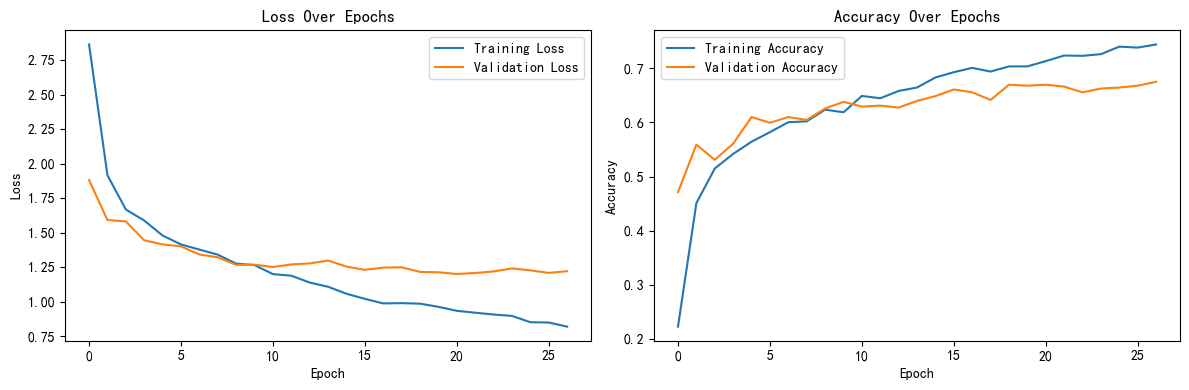

Saved artifact at '/tmp/tmp3zf_7abb'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_6')
Output Type:
  TensorSpec(shape=(None, 36), dtype=tf.float32, name=None)
Captures:
  138668456549008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138668456549392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138668456548624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138668456549776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138668456549968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138668456551120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138668456552464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138668456552848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138668456552656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138668456551312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13866845655

In [23]:
MobileNetV1 = get_MobileNetV1()
show_history(train_model(MobileNetV1))
MobileNetV1_tflite = quantize_and_convert_to_tflite(MobileNetV1)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 27s 121ms/step - accuracy: 0.1440 - loss: 3.2025 - val_accuracy: 0.5079 - val_loss: 1.7571 - learning_rate: 0.0010
Epoch 2/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 19s 117ms/step - accuracy: 0.4723 - loss: 1.8722 - val_accuracy: 0.5958 - val_loss: 1.4815 - learning_rate: 0.0010
Epoch 3/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 16s 99ms/step - accuracy: 0.5467 - loss: 1.6208 - val_accuracy: 0.6098 - val_loss: 1.4214 - learning_rate: 0.0010
Epoch 4/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 20s 99ms/step - accuracy: 0.5732 - loss: 1.4951 - val_accuracy: 0.6151 - val_loss: 1.3756 - learning_rate: 0.0010
Epoch 5/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 20s 99ms/step - accuracy: 0.6036 - loss: 1.4012 - val_accuracy: 0.6309 - val_loss: 1.3215 - learning_rate: 0.0010
Epoch 6/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 15s 91ms/step - accuracy: 0.6364 - loss: 1.2650 - val_accuracy: 0.6151 - val_loss: 1.3402 - learning_rate: 0.0010
Epoch 7/30
161/161 ━━━━━━

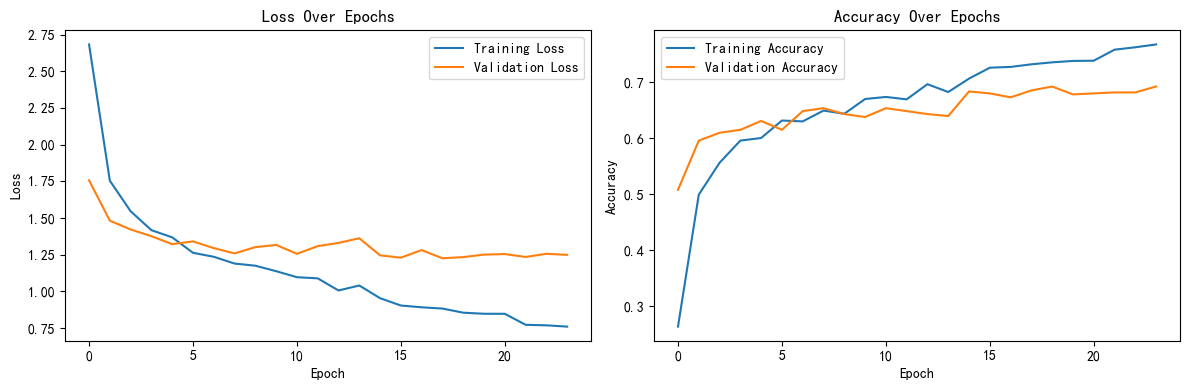

Saved artifact at '/tmp/tmp3txdl53b'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_105')
Output Type:
  TensorSpec(shape=(None, 36), dtype=tf.float32, name=None)
Captures:
  138668497957712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138666367515920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138666367514384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138668456546896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138666367515728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138666367513232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138666367513424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138666367513808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138666367513616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138666367516496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138666367

In [24]:
MobileNetV2 = get_MobileNetV2()
show_history(train_model(MobileNetV2))
MobileNetV2_tflite = quantize_and_convert_to_tflite(MobileNetV2)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 31s 121ms/step - accuracy: 0.2009 - loss: 3.0487 - val_accuracy: 0.5536 - val_loss: 1.5243 - learning_rate: 0.0010
Epoch 2/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 17s 101ms/step - accuracy: 0.5604 - loss: 1.5748 - val_accuracy: 0.6257 - val_loss: 1.3000 - learning_rate: 0.0010
Epoch 3/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 21s 102ms/step - accuracy: 0.6082 - loss: 1.3509 - val_accuracy: 0.6608 - val_loss: 1.1898 - learning_rate: 0.0010
Epoch 4/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 16s 102ms/step - accuracy: 0.6299 - loss: 1.2682 - val_accuracy: 0.6819 - val_loss: 1.1480 - learning_rate: 0.0010
Epoch 5/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 23s 117ms/step - accuracy: 0.6667 - loss: 1.1661 - val_accuracy: 0.6661 - val_loss: 1.1916 - learning_rate: 0.0010
Epoch 6/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 17s 93ms/step - accuracy: 0.6787 - loss: 1.1063 - val_accuracy: 0.6960 - val_loss: 1.1513 - learning_rate: 0.0010
Epoch 7/30
161/161 ━

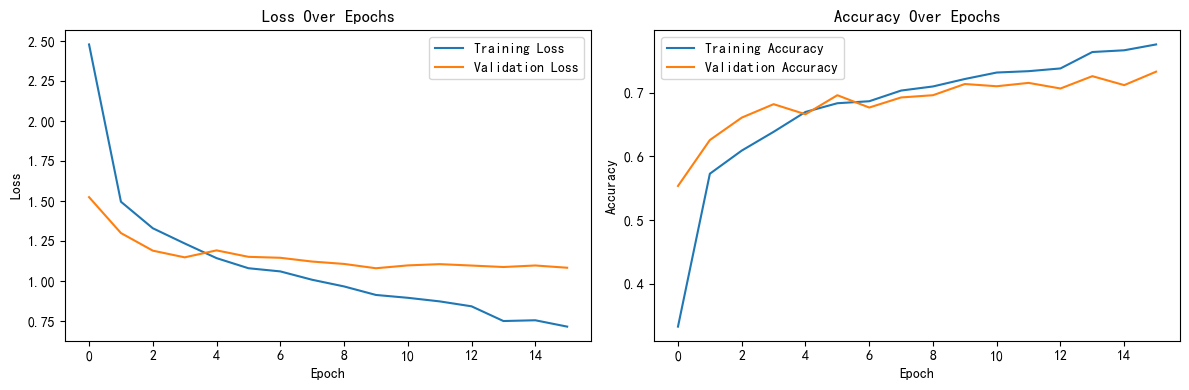

Saved artifact at '/tmp/tmp4fr20xsj'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_272')
Output Type:
  TensorSpec(shape=(None, 36), dtype=tf.float32, name=None)
Captures:
  138666350954448: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  138666350964240: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  138666373451408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138666373451792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138666373452752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138666373451984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138666373448912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138666373453712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138666373453328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138666373454672: TensorSpec(shape=(), dtype=tf.resource, name

In [25]:
EfficientNetB0 = get_EfficientNetB0()
show_history(train_model(EfficientNetB0))
EfficientNetB0_tflite = quantize_and_convert_to_tflite(EfficientNetB0)

171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 62s 287ms/step - accuracy: 0.1718 - loss: 3.1202 - val_accuracy: 0.5325 - val_loss: 1.6456 - learning_rate: 0.0010
Epoch 2/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 41s 253ms/step - accuracy: 0.5020 - loss: 1.7786 - val_accuracy: 0.6239 - val_loss: 1.3756 - learning_rate: 0.0010
Epoch 3/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 41s 254ms/step - accuracy: 0.5428 - loss: 1.5638 - val_accuracy: 0.6327 - val_loss: 1.3436 - learning_rate: 0.0010
Epoch 4/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 40s 247ms/step - accuracy: 0.5893 - loss: 1.3886 - val_accuracy: 0.6538 - val_loss: 1.2423 - learning_rate: 0.0010
Epoch 5/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 41s 255ms/step - accuracy: 0.6095 - loss: 1.3197 - val_accuracy: 0.6714 - val_loss: 1.2212 - learning_rate: 0.0010
Epoch 6/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 81s 247ms/step - accuracy: 0.6335 - loss: 1.1984 - val_accuracy: 0.6731 - val_loss: 1.1584 - learning_rate: 0.0010
Epoch 7/30
161/16

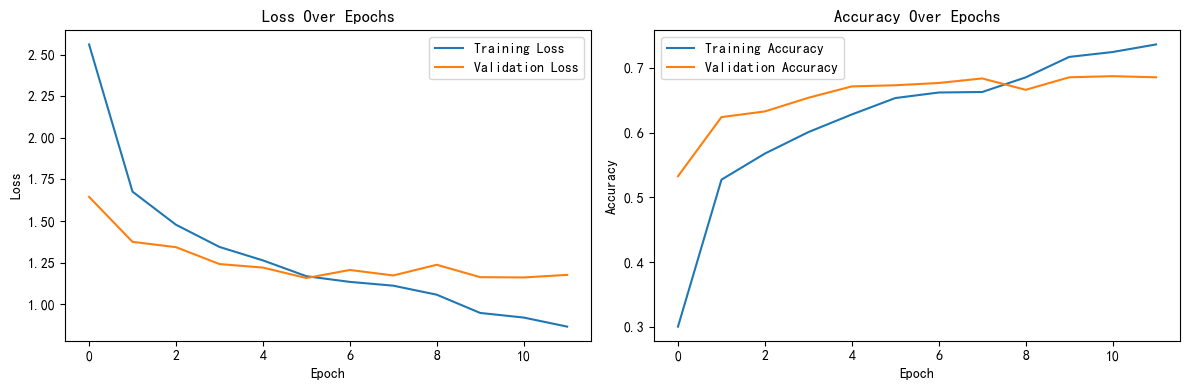

Saved artifact at '/tmp/tmpw7k3jwos'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_521')
Output Type:
  TensorSpec(shape=(None, 36), dtype=tf.float32, name=None)
Captures:
  138664719630608: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  138658434327248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138658434327824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138658434328208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138658434328400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138658434326672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138658434327632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138658434332240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138658434332816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138658434333008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  

In [26]:
ResNet101 = get_ResNet101()
show_history(train_model(ResNet101))
ResNet101_tflite = quantize_and_convert_to_tflite(ResNet101)

# 评估

In [33]:
print("MobileNetV1:\n")
evaluate_model(MobileNetV1, validation_dataset)
evaluate_tflite_model(MobileNetV1_tflite, validation_dataset)
save_model(MobileNetV1_tflite, "MobileNetV1.tflite")

print("\nMobileNetV2:\n")
evaluate_model(MobileNetV2, validation_dataset)
evaluate_tflite_model(MobileNetV2_tflite, validation_dataset)
save_model(MobileNetV2_tflite, "MobileNetV2.tflite")

print("\nEfficientNetB0:\n")
evaluate_model(EfficientNetB0, validation_dataset)
evaluate_tflite_model(EfficientNetB0_tflite, validation_dataset)
save_model(nEfficientNetB0_tflite, "nEfficientNetB0.tflite")

print("\nResNet101:\n")
evaluate_model(ResNet101, validation_dataset)
evaluate_tflite_model(ResNet101_tflite, validation_dataset)
save_model(ResNet101_tflite, "ResNet101.tflite")


MobileNetV1:

Loss: 1.1923
Top-1 Accuracy: 0.6696
Top-5 Accuracy: 0.9104
Model Size: 12.98 MB
TFLite模型 Top-1 准确率: 0.6696
TFLite模型 Top-5 准确率: 0.9033
TFLite模型大小: 3.40 MB
MobileNetV2:

Loss: 1.2205
Top-1 Accuracy: 0.6854
Top-5 Accuracy: 0.9051
Model Size: 9.40 MB
TFLite模型 Top-1 准确率: 0.6749
TFLite模型 Top-5 准确率: 0.9051
TFLite模型大小: 2.59 MB
EfficientNetB0:

Loss: 1.0735
Top-1 Accuracy: 0.7135
Top-5 Accuracy: 0.9086
Model Size: 16.23 MB
TFLite模型 Top-1 准确率: 0.6977
TFLite模型 Top-5 准确率: 0.9069
TFLite模型大小: 4.54 MB
ResNet101:

Loss: 1.1554
Top-1 Accuracy: 0.6731
Top-5 Accuracy: 0.9174
Model Size: 163.89 MB
TFLite模型 Top-1 准确率: 0.6696
TFLite模型 Top-5 准确率: 0.9174
TFLite模型大小: 41.60 MB


(np.float32(0.6695958), np.float32(0.9173989), 41.602333068847656)